## HousPrice prediction in Poland

Importing needed libraries

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)

Loading and exploring the dataset

In [35]:

df = pd.read_csv('Bengaluru_House_Data.csv')

In [36]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [37]:
df.shape

(13320, 9)

In [38]:
#checking how many houses per area_type we have 
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [39]:
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

#### Data cleaning

In [41]:
# deleting not needed columns
df2 = df.drop(['area_type', 'society','balcony', 'availability'], axis = 'columns')

In [42]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [44]:
#checking for missing values in the dataframe 
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [47]:
# since we had just so little missing values we are dropping them, it shouldn't have a significant influence on the predictions later on
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [49]:
#checking for unique values in size, since in exploring the dataset we found some different descriptions of size 
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [53]:
# creating a new column which only contains the number of size as the number for rooms, without the desription

#applying a function on the size column to extract and safe the number of rooms as an integer 
# 1. taking the string in the size column and tokenizing it with space ' '. 
#    we will use a lambda function for that
#    x stands for the value per each row of df3 and its value in 'size' column 
# 2. split(' ') gives us two token, then we want to take the first token [0]
# 3. int() we want to take the first token as an integer not as a string
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\wh\AppData\Local\Temp/ipykernel_30748/1851105200.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [57]:
# checking the bhk column if it worked
df3.bhk.unique()



array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [59]:
#checking the remaining values for houses with mor than 20 rooms
df3[df3['bhk']>20]
# it seems odd, that a house with 43 rooms has a total_sqft of only 2400
# let's tackle it later on

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [61]:
# exploring the total_sqft column
df3.total_sqft.unique()
# some values are not just numbers but ranges
# let's fill them up with their mean


array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [62]:
# detecting if values in total_sqft are single values or range
# try to convert the value to an float, won't work with ranges
# if it doesn't work return False, if it worked return True
def is_float(x): 
    try:
        float(x)
    except:
        return False
    return True

In [66]:
#applying the function on total_sqft
# ~ returns a dataframe with just the not converted values
df3[~df3['total_sqft'].apply(is_float)].head(10)
# look at id 410 it's not even a range

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [70]:
#defining a new function which converts the ranges and calculates it means, other irregularities are ignored
# 1. splitting the values into two tokens and saving it in tokens variable
# 2. if it was a range, the length should be 2, in this case we are calculating its mean
# 3. if the value is a simle number just take it and save it as float
# 4. all other cases different than single number or range won't be saved
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except: 
        return None

In [71]:
# creating a new dataframe for each step, so in case something goes wrong we still have old version
# creating new column with total_sqft
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


#### Feature engineering

In [ ]:
# as mentioned before, we are creating a copy of df 4 just to have more versions in case something goes wrong

In [73]:
df5 = df4.copy()

In [76]:
# creating a new column which might be useful for predictions later on
# since the price is in float nmber to have a better overview, we need to multiply it by 10,000, this will give us the full price
# so a price of 10 is in reality 1 million lakh
df5['price_sqft'] = df5['price']*10000 / df5['total_sqft']

In [78]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,369.981061
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,461.538462
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,430.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,624.589086
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,425.000000


In [80]:
# checking out the location feature
len(df5.location.unique())
# that's a lot of unique values
# locations is acategorical value, in machine learning we dummify it and get columns per unique value in location
# this would be too much with 1304 columns


# so let's create a other value, which contains values that don't appear regurarly


1304

In [84]:
# striping extra spaces to have clean data with x.strip()
# then creating a cariable of location with grouping it by location and then counting t how often certain locations appear
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5.groupby('location')['location'].agg('count')

In [87]:
location_stats.sort_values(ascending=False)
# so let's say that some locations that appear less than 11 times wwill be labeled as other

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [89]:
len(location_stats[location_stats<=10])
#we have 1052 different locations which appear less than 11 times

#btw since location_stats is a series we can take location_stats as its condition

1052

In [90]:
location_smaller_10 = location_stats[location_stats<=10]
# saving the locations to use it for the categorization


In [92]:
# labeling others for locations which appear less than 11 times
# if x is in the location_smaller_10 series it will be labeld as 'other', else we keep the original value/location

df5.location = df5.location.apply(lambda x: 'other' if x in location_smaller_10 else x)

# now we have ony 242 different values
len(df5.location.unique())

242

#### Outlier detection & removal


In [95]:
# so e.g. the real estate manager says that the thresold for an apartment with some rooms ist 300 sqft per room
# i this cas we can spot outliers which have on average less than 300 sqft per room

df5[df5.total_sqft/df5.bhk < 300].head()

,location,size,total_sqft,bath,price,bhk,price_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,3627.450980
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,3333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,1066.098081
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,629.629630
70,other,3 Bedroom,500.0,3.0,100.0,3,2000.000000


In [98]:
print(df5.shape)
print(len(df5[df5.total_sqft/df5.bhk < 300]))
#so in total we have 744 houses were the sqft per room seems odd
#let's remove it 

(13246, 7)
744


In [102]:
df6 = df5[~(df5.total_sqft/df5.bhk < 300)]
df6.shape
#744 hoses were removed

(12502, 7)

In [103]:
#let's check price_sqft to check for outliers in bot directions
df6.price_sqft.describe()

count    12456.000000
mean       630.850283
std        416.812734
min         26.782981
25%        421.052632
50%        529.411765
75%        691.666667
max      17647.058824
Name: price_sqft, dtype: float64

In [111]:
#removing outliers per location, since locations will hace different price structure

# 1. taking a dataframe as input
# 2. grouping the df by location and then creating a subdf 
# 3. for eac subdf we are calculating the mean and std. dev. 
# 4. filtering the subdf for values which lay within a one std. dev from the mean
# 5. creating a df_out and concatinating it with all subdf
# 6. returning df<-out <8df with data within one std dev


def remove_psqft_p_location(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_sqft)
        sd = np.std(subdf.price_sqft)
        reduced_df = subdf[(subdf.price_sqft > (m-sd)) & (subdf.price_sqft < (m+sd))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [114]:
df7 = remove_psqft_p_location(df6)
df7.shape

# around 2000 outliers removed

(10241, 7)

In [123]:
# visualizing if there are strange things like similar sqft but houses with less rooms have a higher prive than houses with higher number of rooms

# 1. creating a function which takes two inputs, a dataframe and location
# 2. setting up two variables which will be compared, in this case apartments from the same location and one having 2 rooms and the other one 3 rooms
# 3. setting the figsize
# 4. adding the two variables to be displayed
#    passing them attribtes how to be displayed
# 5. adding labels, title and legend

def plot_scatter(df, location):
    bhk2 = df[(df.location ==location) & (df.bhk == 2)]
    bhk3 = df[(df.location ==location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker ='+', color='red', label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

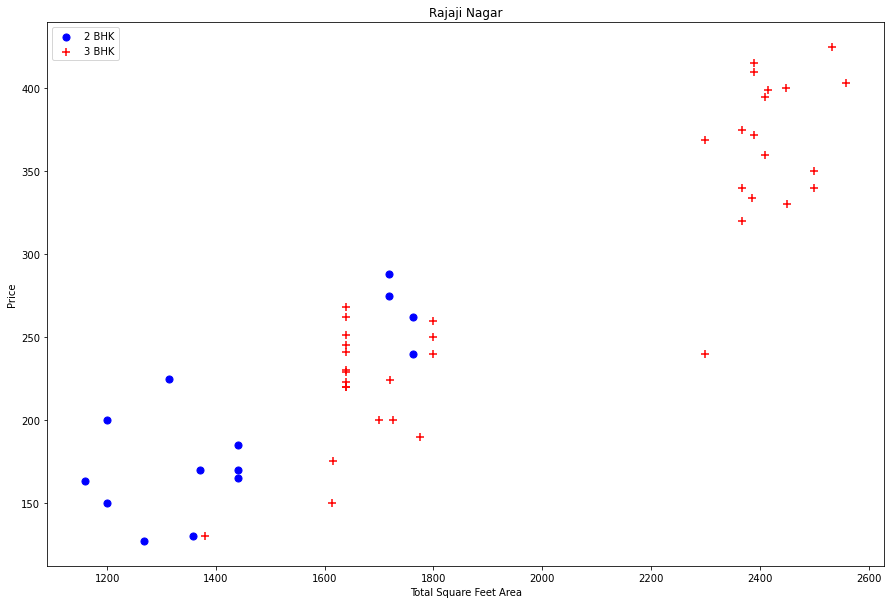

In [124]:
plot_scatter(df7, 'Rajaji Nagar')

e.g. for houses with 1700, 1750 sqft the prices are higher for 2 bhk than for 3 bhk 
let's remove the outliers

Therfore we will delete properties with more rooms but the same or lower price
for this we will create a dictionary with 3 metrics (mean, std, count) for each value for bhk

In [126]:
# 1. funtion takes df as input
# 2. creating an empty array which later on will be filled
# 3. first iteration iterates trough df and groups by location
# 4. creating a bhk dictonary
# 5. for each distinct bhk value the dictionary will be filles with mean, std. dev and observation count
# 6. then we take the last bhk and safe its metrics i stats variable
# 7. if stats has more than 5 observsations we exclude values from bhk_df were the price_sqft is lower than the mean of the previous bhk


def remove_bhk_outliers (df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_sqft),
                'std' : np.std(bhk_df.price_sqft),
                'count': bhk_df.price_sqft.count()
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices= np.append(exclude_indices, bhk_df[bhk_df.price_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')

In [128]:
df8 = remove_bhk_outliers(df7)
df8.shape

(7329, 7)

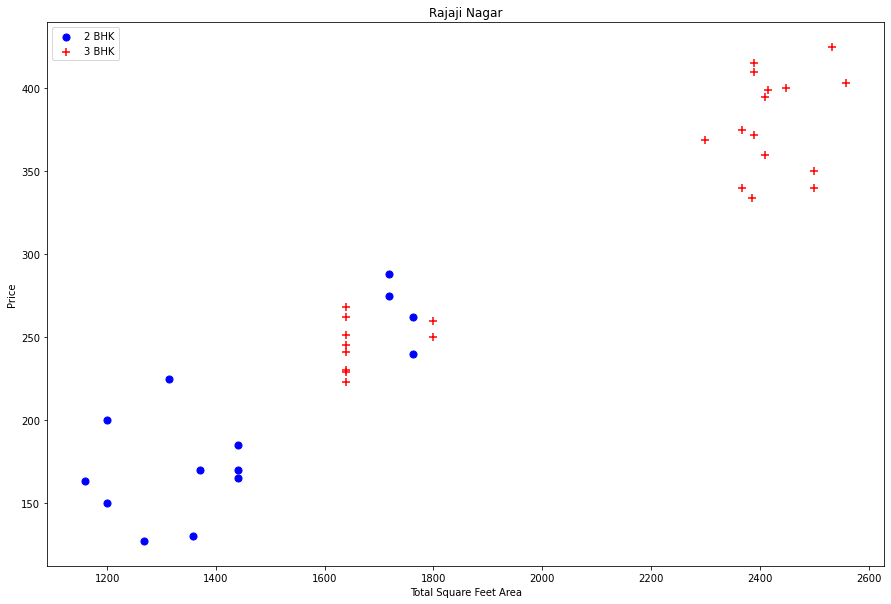

In [129]:
plot_scatter(df8, 'Rajaji Nagar')

houses with same sqft and more bhk but lower price are removed


Text(0, 0.5, 'Count')

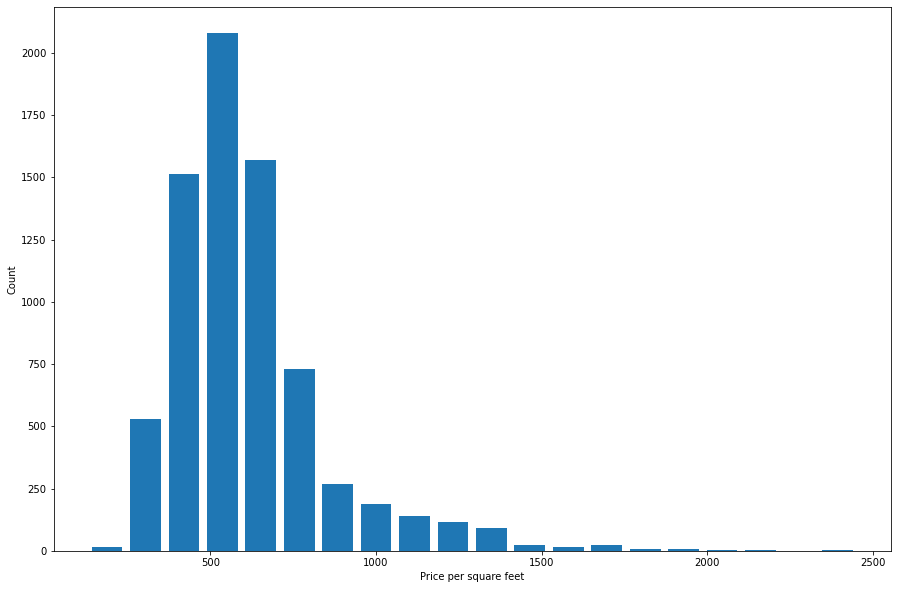

In [131]:
# ploting a histogram too see the price per sqft distribution

plt.hist(df8.price_sqft, rwidth=0.8, bins=20)
plt.xlabel('Price per square feet')    
plt.ylabel('Count')

In [133]:
# next we are exploring the bathrom feature

df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [135]:
df8[df8.bath>10]
#after consulting with the manager he says that it's pretty unusual when a house has  has more bathromms than rooms plus 2


,location,size,total_sqft,bath,price,bhk,price_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,400.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,437.500000
8575,other,16 BHK,10000.0,16.0,550.0,16,550.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,250.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,506.912442


In [137]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,325.203252
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,642.857143
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,642.303433
8411,other,6 BHK,11338.0,9.0,1000.0,6,881.989769


In [144]:
# dropping the outliers
df9 = df8[df8.bath<=df8.bhk+2]
df9.shape

(7325, 7)

In [145]:
df8.shape

(7329, 7)

In [146]:
# after cleaning the dataset of outliers, we can delete unnecessary columns
# price_sqft was only created for outlier detection and is no longer needed, since we will predict the price of the property
# size can be also removed as we have extracted the number of rooms and stored it in a seperate column

#### Model building